In [1]:
!pip install fastdtw
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512613 sha256=245d47f8c2c584e1b7cc5e4b3b074efb313aedd628b3264fbf92ab929d59c1a3
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [2]:
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sbn
import pandas as pd
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

Dynamic Time Warping on MFCC audios

In [3]:
AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/ImAudible/audio"

In [4]:
caption_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project/ImAudible/imaudible_caption.csv')
files = caption_df.painting.values

In [5]:
name2feat = {}
for i in files:
  x,sr = librosa.load(f'{AUDIO_PATH}/{i}.wav')
  feat = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20)
  name2feat[i] = feat.reshape(-1)

In [6]:
def d(audio_feat1, audio_feat2):

  res = np.sqrt(np.sum((audio_feat1 - audio_feat2)**2))

  return res

In [7]:
dtws = torch.zeros((15,15))
for i,file_i in enumerate(files):
  for j,file_j in enumerate(files):
    if file_i==file_j :
      continue

    dtws[i,j] = fastdtw(name2feat[file_i], name2feat[file_j], dist=d)[0]

In [8]:
dtws_np = np.array(dtws)

Feature clipping

In [9]:
mu = dtws_np.mean()
std = dtws_np.std()

In [10]:
up_bound = mu + 3 *std
low_bound = mu - 3*std
clipped = 0
for i in range(15):
  for j in range(15):
    if i == j:
      continue
    if dtws_np[i,j] >= up_bound:
      dtws_np[i,j] = up_bound
      clipped += 1
    elif dtws_np[i,j] <= low_bound:
      dtws_np[i,j] = low_bound
      clipped += 1
print(f'Cliped : {clipped}')

Cliped : 2


Min-max normalization

In [11]:
max_value = dtws_np.max()
max_value

427274.8

In [12]:
mask = np.ones(dtws_np.shape, dtype=bool)
np.fill_diagonal(mask, 0)
min_value = dtws_np[mask].min()
min_value

110022.67

In [13]:
for i in range(15):
  for j in range(15):
    if i == j:
      continue

    dtws_np[i,j] = (dtws_np[i,j] - min_value) / (max_value - min_value)

In [14]:
files = list(map(lambda x : x.replace("_"," "), files))

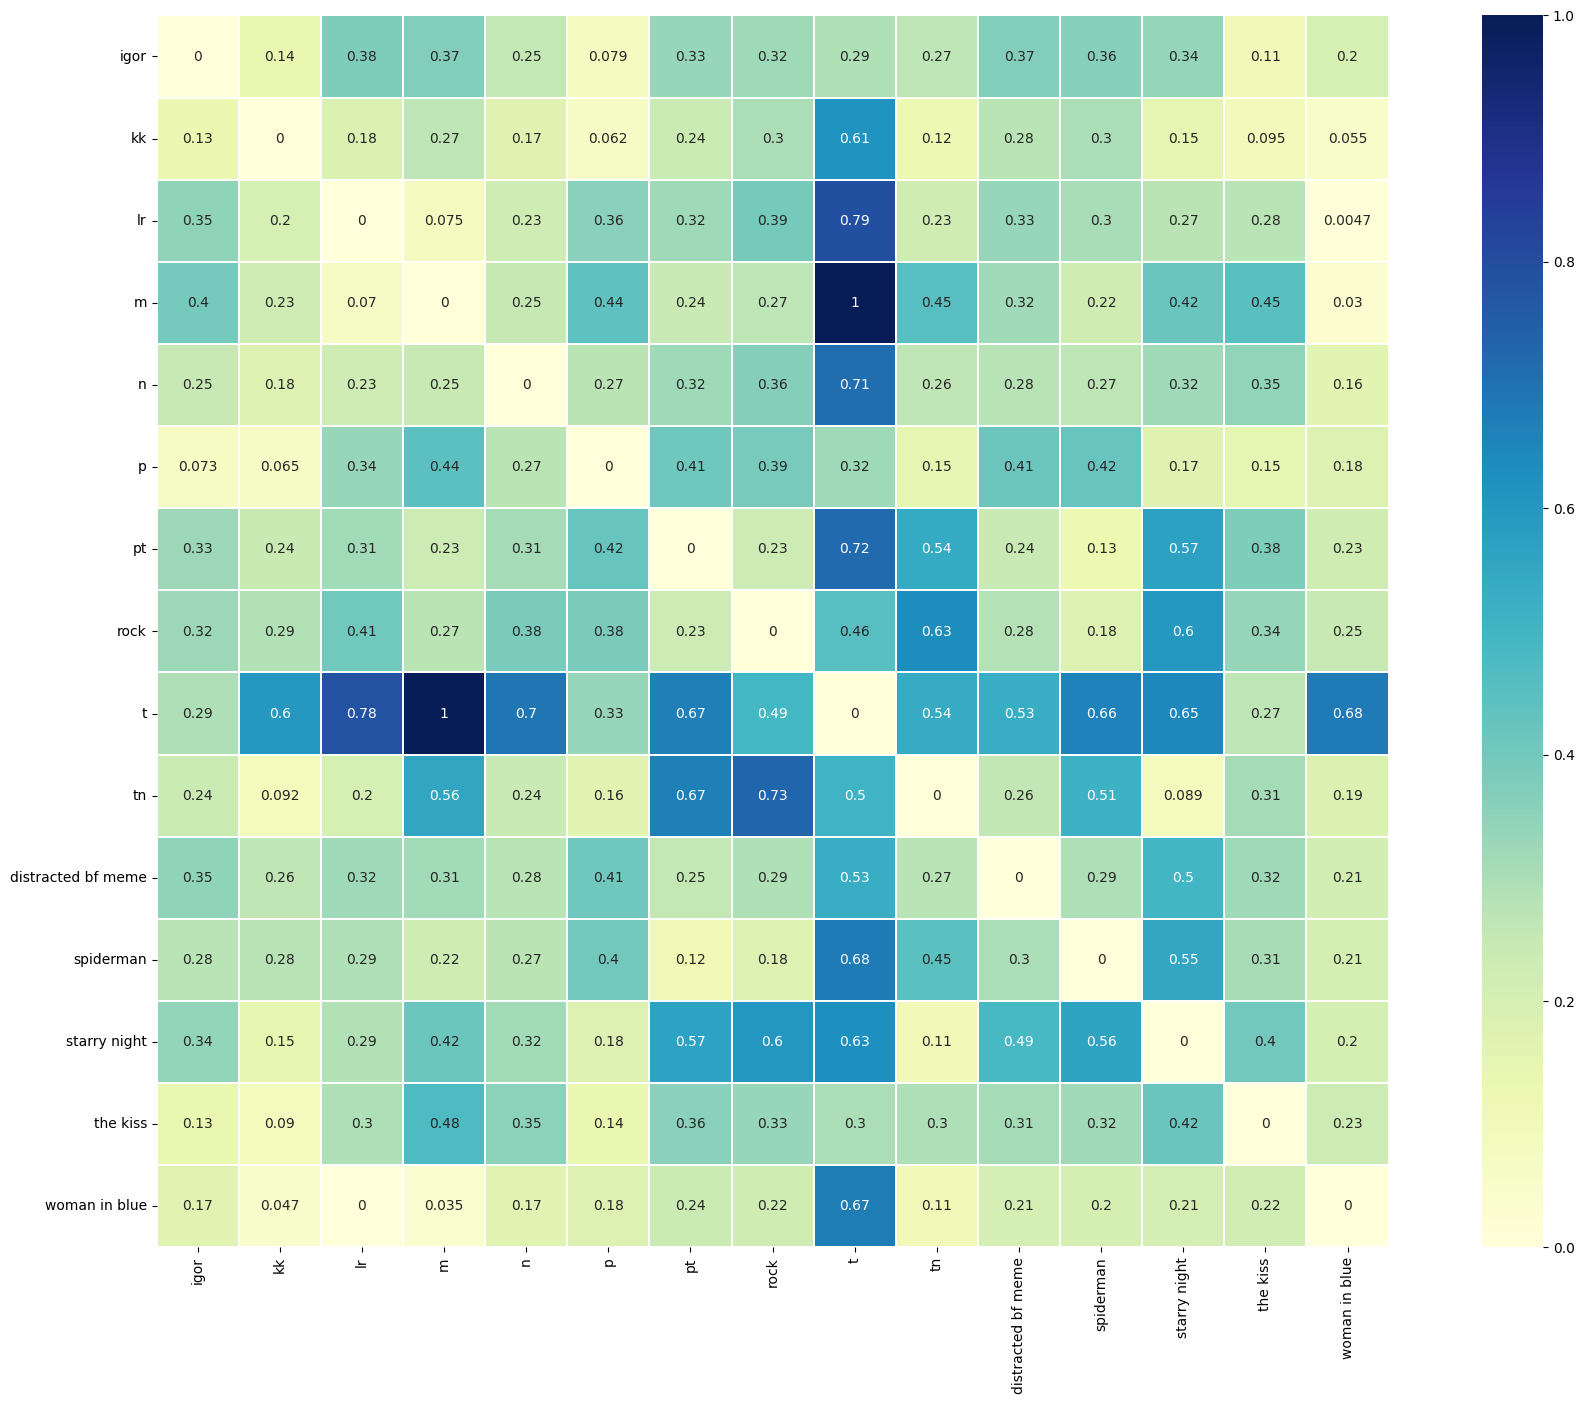

In [15]:
fig, ax = plt.subplots(figsize=(24, 16))
sbn.heatmap(dtws_np, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", xticklabels=files, yticklabels=files,ax=ax)
plt.show()

In [26]:
dtws = torch.save(dtws_np,"./dtws.pt")